In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from matplotlib.colors import ListedColormap

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 100000
signal_to_noise = 4



L = 6

ranks = np.array([30, 20, 10, 5, 4, 1])
rank = ranks.sum()

nsamples = rank * 4
nsamples

280

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, 33, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=100000.0
level=1, num_groups=3, mean_size=33333.3
level=2, num_groups=7, mean_size=14285.7
level=3, num_groups=16, mean_size=6250.0
level=4, num_groups=32, mean_size=3125.0
level=5, num_groups=100000, mean_size=1.0


In [5]:
F_hpart = {"pi": hpart['rows']["pi"], "lk": hpart['rows']["lk"][:-1]}
true_mfm = mfm.MFModel()
true_mfm = mfm.generate_mfmodel(true_mfm, n, F_hpart, ranks, signal_to_noise, debug=False)
F_hpart["pi_inv"] = true_mfm.pi_inv

signal_var=86.15426942204937, noise_var=17.248788440992815
SNR=3.994801212663633, signal_to_noise=4


(100000, 368)


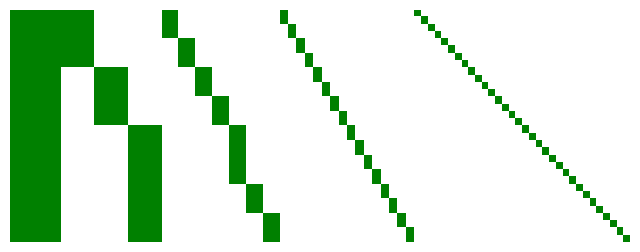

In [16]:
true_sparse_F = mf.convert_compressed_to_sparse(true_mfm.F, 
                                             F_hpart, 
                                             ranks[:-1]).toarray()
print(true_sparse_F.shape)
cmap = ListedColormap(['white', 'green'])
plt.figure(figsize=(8, 3)) 
plt.matshow(true_sparse_F!=0, aspect='auto', fignum=1, cmap=cmap) 
plt.axis('off')
# plt.show()

# Save the figure to a PDF file
plt.savefig('plots/large_F_sparsity.pdf', bbox_inches='tight', pad_inches=0)
# plt.close()
del true_sparse_F

In [7]:
n, true_mfm.num_factors(), L, ranks.sum()

(100000, 368, 6, 70)

In [8]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-12, max_iter=1, printing=True)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

terminated with residual/v_norm=2.118034355774695e-11
solve reldiff=2.118034355774695e-11


In [9]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-9, max_iter=1, printing=False)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

solve reldiff=2.710444316666527e-11


In [10]:
%timeit true_mfm.solve(v, eps=1e-9, max_iter=1, printing=False)

115 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
true_mfm.D.min(), true_mfm.D.max()

(0.0006434164064850813, 34.45142841402845)

# EM

In [12]:
C = mfm.sample_data(nsamples, true_mfm)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
# unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mfm.pi_inv, :][:, true_mfm.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=6, num_sparsities=32
(32, 5) [ 0  2  6 15 31]


In [13]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=15, freq=5)

t=0, obj=-358298.1034812714
t=5, obj=-272510.0192366316
t=10, obj=-267171.7080406353
t=14, obj=-265448.75648376724


In [14]:
fitted_mfm.inv_coefficients()
obj_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_mfm.F, np.sqrt(true_mfm.D).reshape(-1, 1)], axis=1), 
                                                        fitted_mfm, ranks, hpart["rows"], F_hpart, 
                                                        row_selectors, si_groups, tol1=1e-12, tol2=1e-12)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")

ML: train ll=-265448.75648376724, exp ll=-306361.17948083015


In [15]:
rank, fitted_mfm.num_factors()

(70, 368)